In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time 
from tqdm.notebook import tqdm

In [2]:
from path_overlap import * 

In [3]:
num_dense, num_sparse = 5, 5
tot_units = num_dense + num_sparse
density = .2
num_layers = 7
MPG = multipartite_network(num_layers, num_dense, num_sparse, density)

In [4]:
pos = nx.multipartite_layout(MPG)

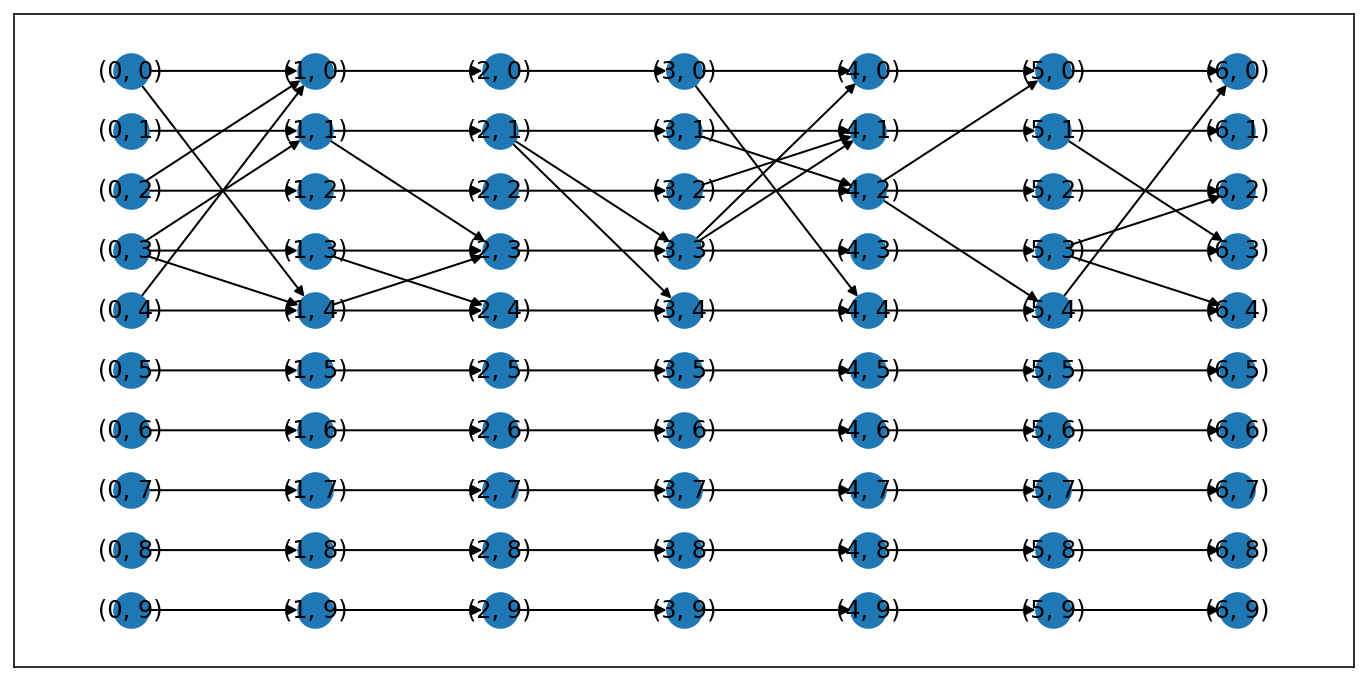

In [5]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(MPG, pos)

In [6]:
rew_MPG, counts = rewire_multipartite_network(MPG, tot_units, rewire_prob=.9, verbose=True, rewire_iters=20)

In [7]:
rew_pos = nx.multipartite_layout(rew_MPG)

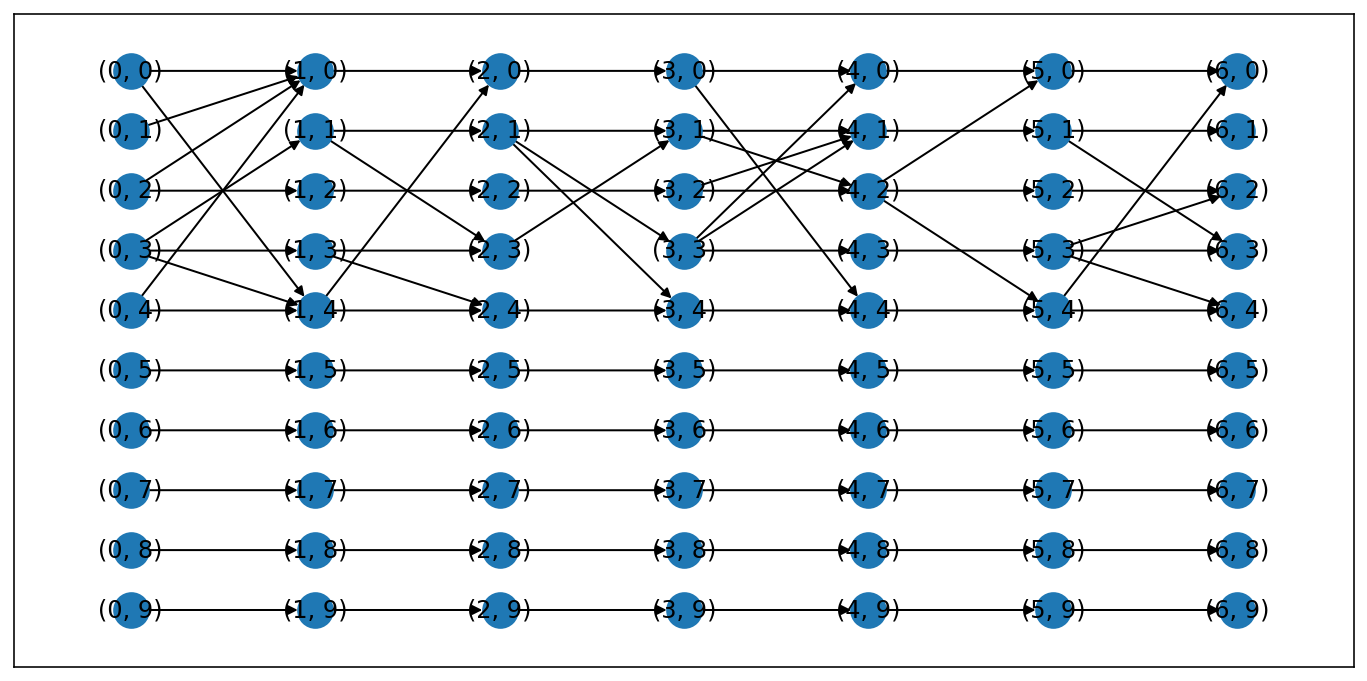

In [8]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(rew_MPG, pos)

In [9]:
from itertools import combinations, product
output_nodes = [(num_layers-1, x) for x in range(tot_units)]
input_nodes = [(0, x) for x in range(tot_units)]

paths = {}
for n, nn in product(input_nodes, output_nodes):
    paths[(n, nn)] = list(nx.all_simple_paths(MPG, n, nn));
    
rew_paths = {}
for n, nn in product(input_nodes, output_nodes):
    rew_paths[(n, nn)] = list(nx.all_simple_paths(rew_MPG, n, nn));

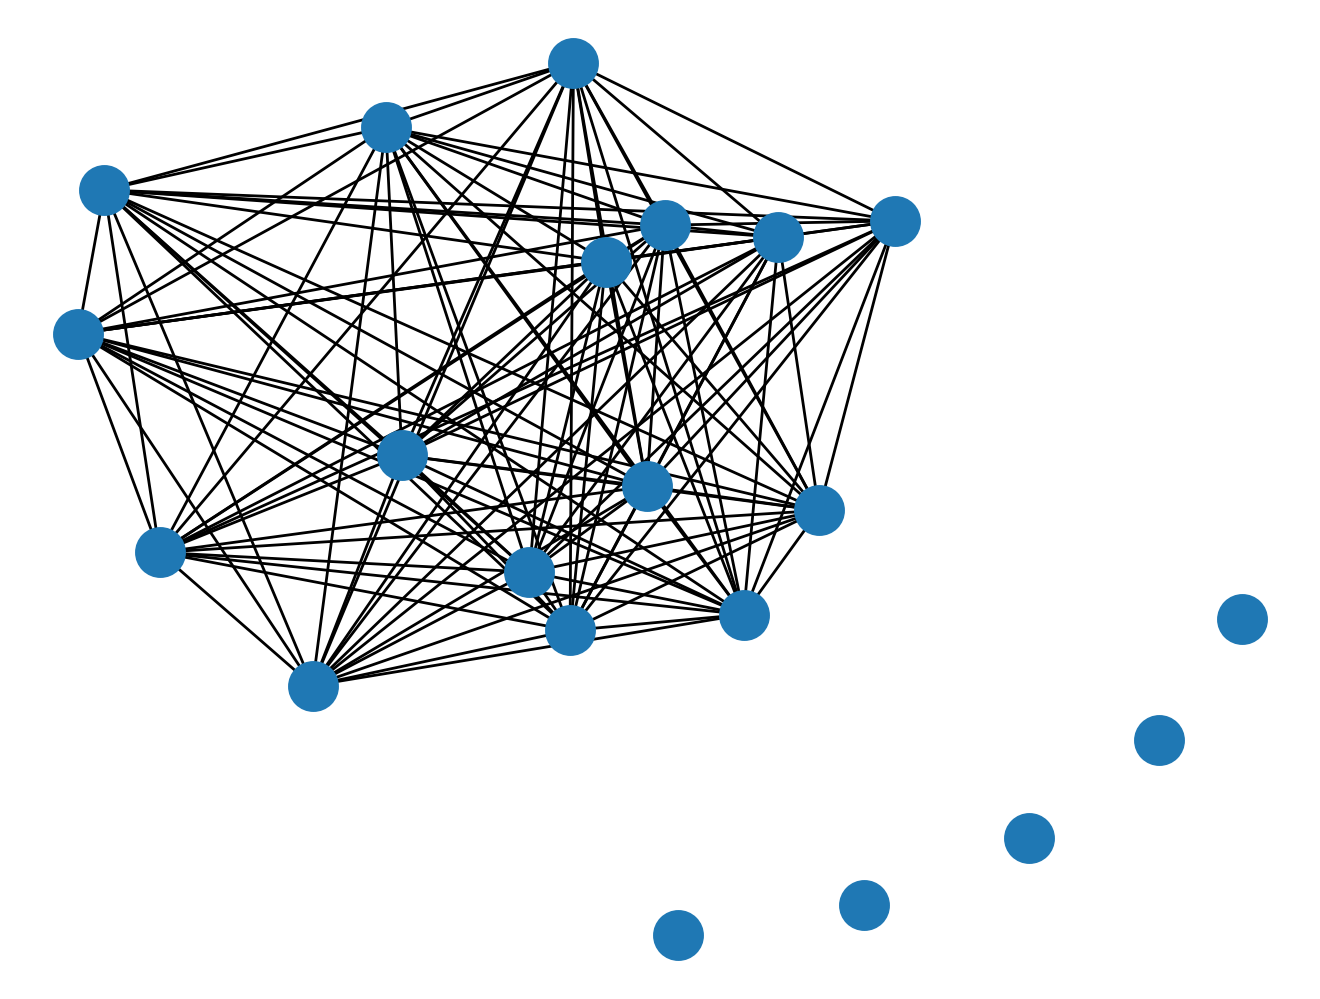

In [46]:
rew_IG, rew_paths = MP_interference_graph(rew_MPG);
nx.draw_kamada_kawai(rew_IG)

In [47]:
def interference_complex(graph, paths, max_simplex_dimension):
    SC = {};
    SC[1] = {}
    for n in paths:
        SC[1][n] = 0;
    for k in range(2, max_simplex_dimension+2):
        SC[k] = {}
        for simplex in combinations(paths, k):
            path_families = [paths[s] for s in simplex]
            w = HO_interference(path_families, graph);
            if w!=None and w>0:
                SC[k][simplex] = w;
    return SC;

In [48]:
relabel_dict = dict(zip(list(paths.keys()), range(len(paths.keys()))))

In [49]:
rew_SC = interference_complex(rew_MPG, rew_paths, 2)

In [50]:
def relabel_SC(sc, rl_dict):
    rl_sc = {};
    for d in sc:
        rl_sc[d] = {}
        if d==1:
            for simp in sc[d]:
                new_simp = frozenset([rl_dict[simp]]);
                rl_sc[d][new_simp] = sc[d][simp];
        else:
            for simp in sc[d]:
                new_simp = frozenset([rl_dict[x] for x in simp]);
                rl_sc[d][new_simp] = sc[d][simp];
    return rl_sc;

In [51]:
rl_SC = relabel_SC(rew_SC, relabel_dict)

In [52]:
def preliminary_interference_SC_filtration(sc):
    fil = [];
    for d in sc:
        for simp in sc[d]:
            fil.append((list(simp), sc[d][simp]))
    return fil;

def interference_filtration_closure(fil, sc, epsilon=0.001):
    filled_fil = fil.copy();
    dims = sorted(list(sc.keys()));
    for d in dims[::-1]:
        if d==1:
            continue;
        for simp in sc[d]:
            for subface in combinations(simp, d-1):
                if subface not in sc[d-1]:
                    filled_fil.append([list(subface), sc[d][simp] -  epsilon])
    return filled_fil;

<BarContainer object of 3 artists>

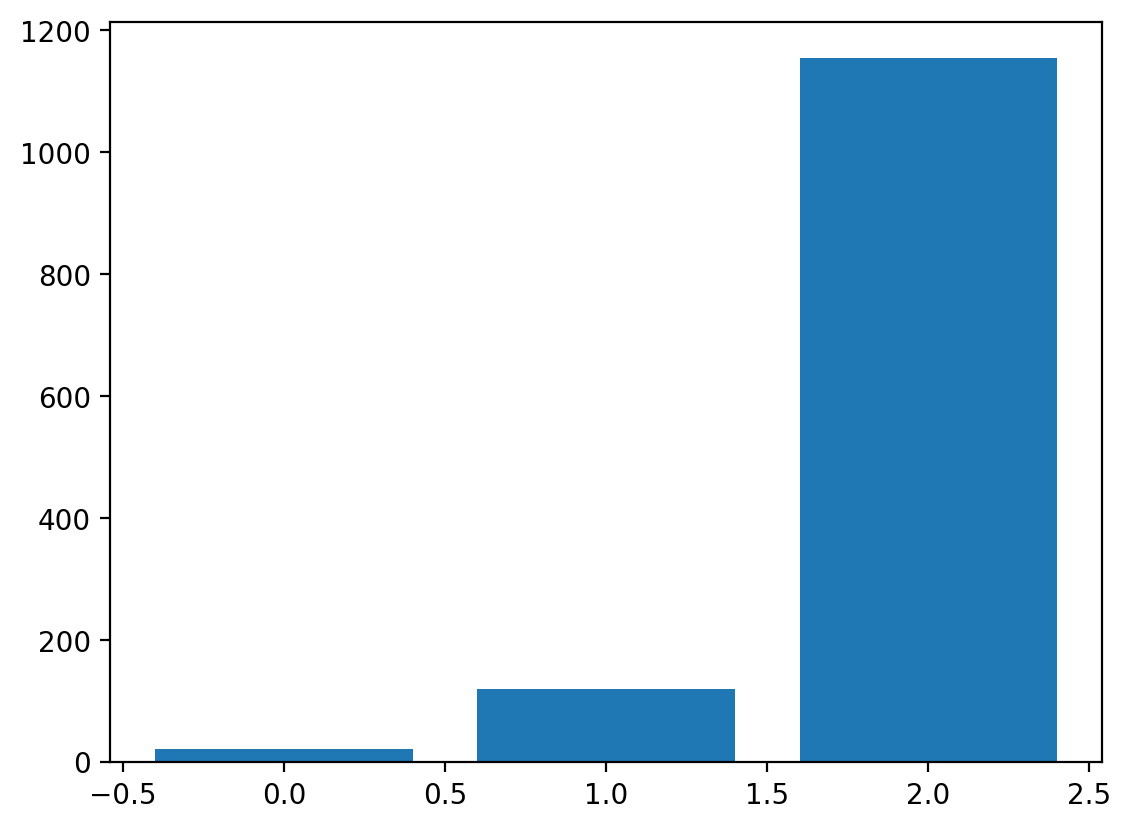

In [53]:
plt.bar([0,1,2], list(map(len, rl_SC.values())))


In [54]:
rl_fil = preliminary_interference_SC_filtration(rl_SC)
rl_filled_fil = interference_filtration_closure(rl_fil, rl_SC)

In [55]:
#Compute persistence diagrams
import cechmate as cm
dgms = cm.phat_diagrams(rl_filled_fil, show_inf = True)
print("H0:\n", dgms[0])
print("H1:\n", dgms[1])

Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.046)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.0117)
H0:
 [[0.         0.124     ]
 [0.         0.124     ]
 [0.         0.124     ]
 [0.         0.124     ]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.                inf]
 [0.999             inf]
 [0.999             inf]
 [0.999             inf]
 [0.999             inf]
 [0.999             inf]
 [0.999             inf]
 [0.999             inf]
 [0.999             inf]
 [0.399             inf]
 [0.399             inf]
 [0.999             inf]
 [0.999       

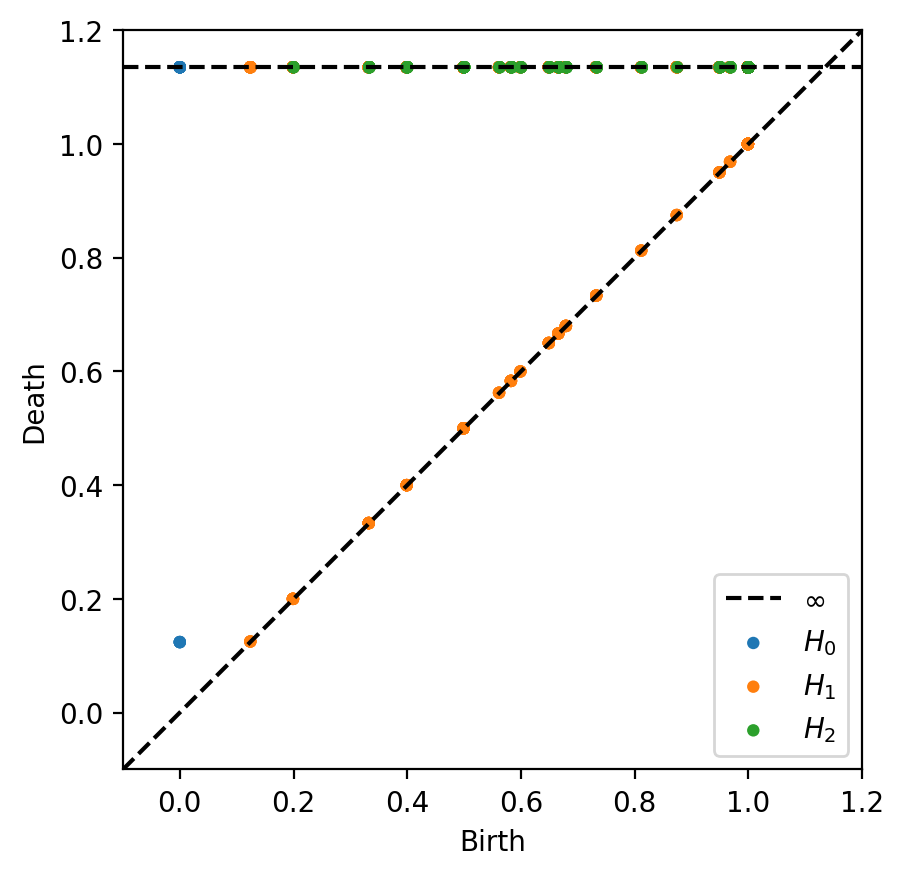

In [58]:
from persim import plot_diagrams
plot_diagrams(dgms)

In [22]:
from simplex_drawings import *

In [59]:
def inv_filtration(fil):
    inv_fil = {}
    for dim in fil:
        for el in fil[dim]:
            if fil[dim][el] not in inv_fil:
                inv_fil[fil[dim][el]] = []
            inv_fil[fil[dim][el]].append(el)
    return inv_fil;

In [60]:
def graph_skeleton(fil):
    skel = nx.Graph();
    nodes = []
    for node in fil[1]:
        nodes.append(list(node)[0])
    skel.add_nodes_from(nodes);
    edges = []
    for edge in fil[2]:
        edges.append(tuple(list(edge)));
    skel.add_edges_from(edges);
    return skel;
    
skel = graph_skeleton(rl_SC)

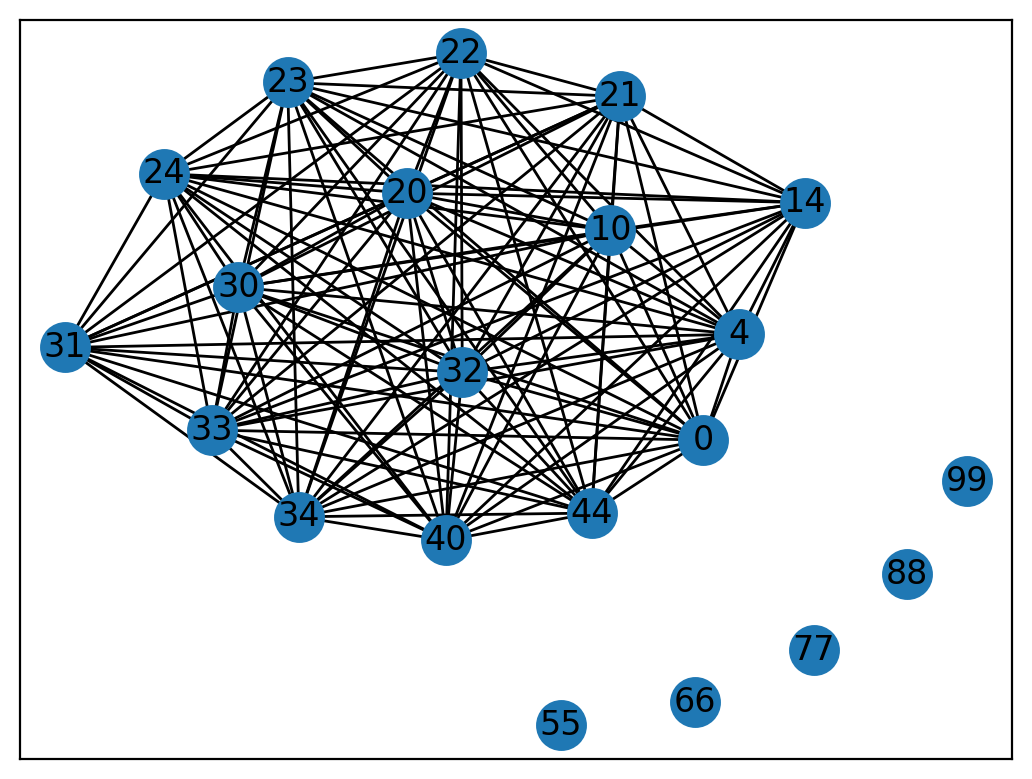

In [67]:
skel_pos = nx.kamada_kawai_layout(skel)
nx.draw_networkx(skel, skel_pos)

In [62]:
inv_rl_SC = inv_filtration(rl_SC)

In [65]:
def instant_complex(inv_fil, t):
    simplex_list = []
    for k in sorted(inv_fil.keys()):
        if k<=t:
            simplex_list.extend(inv_fil[k])
    return simplex_list;

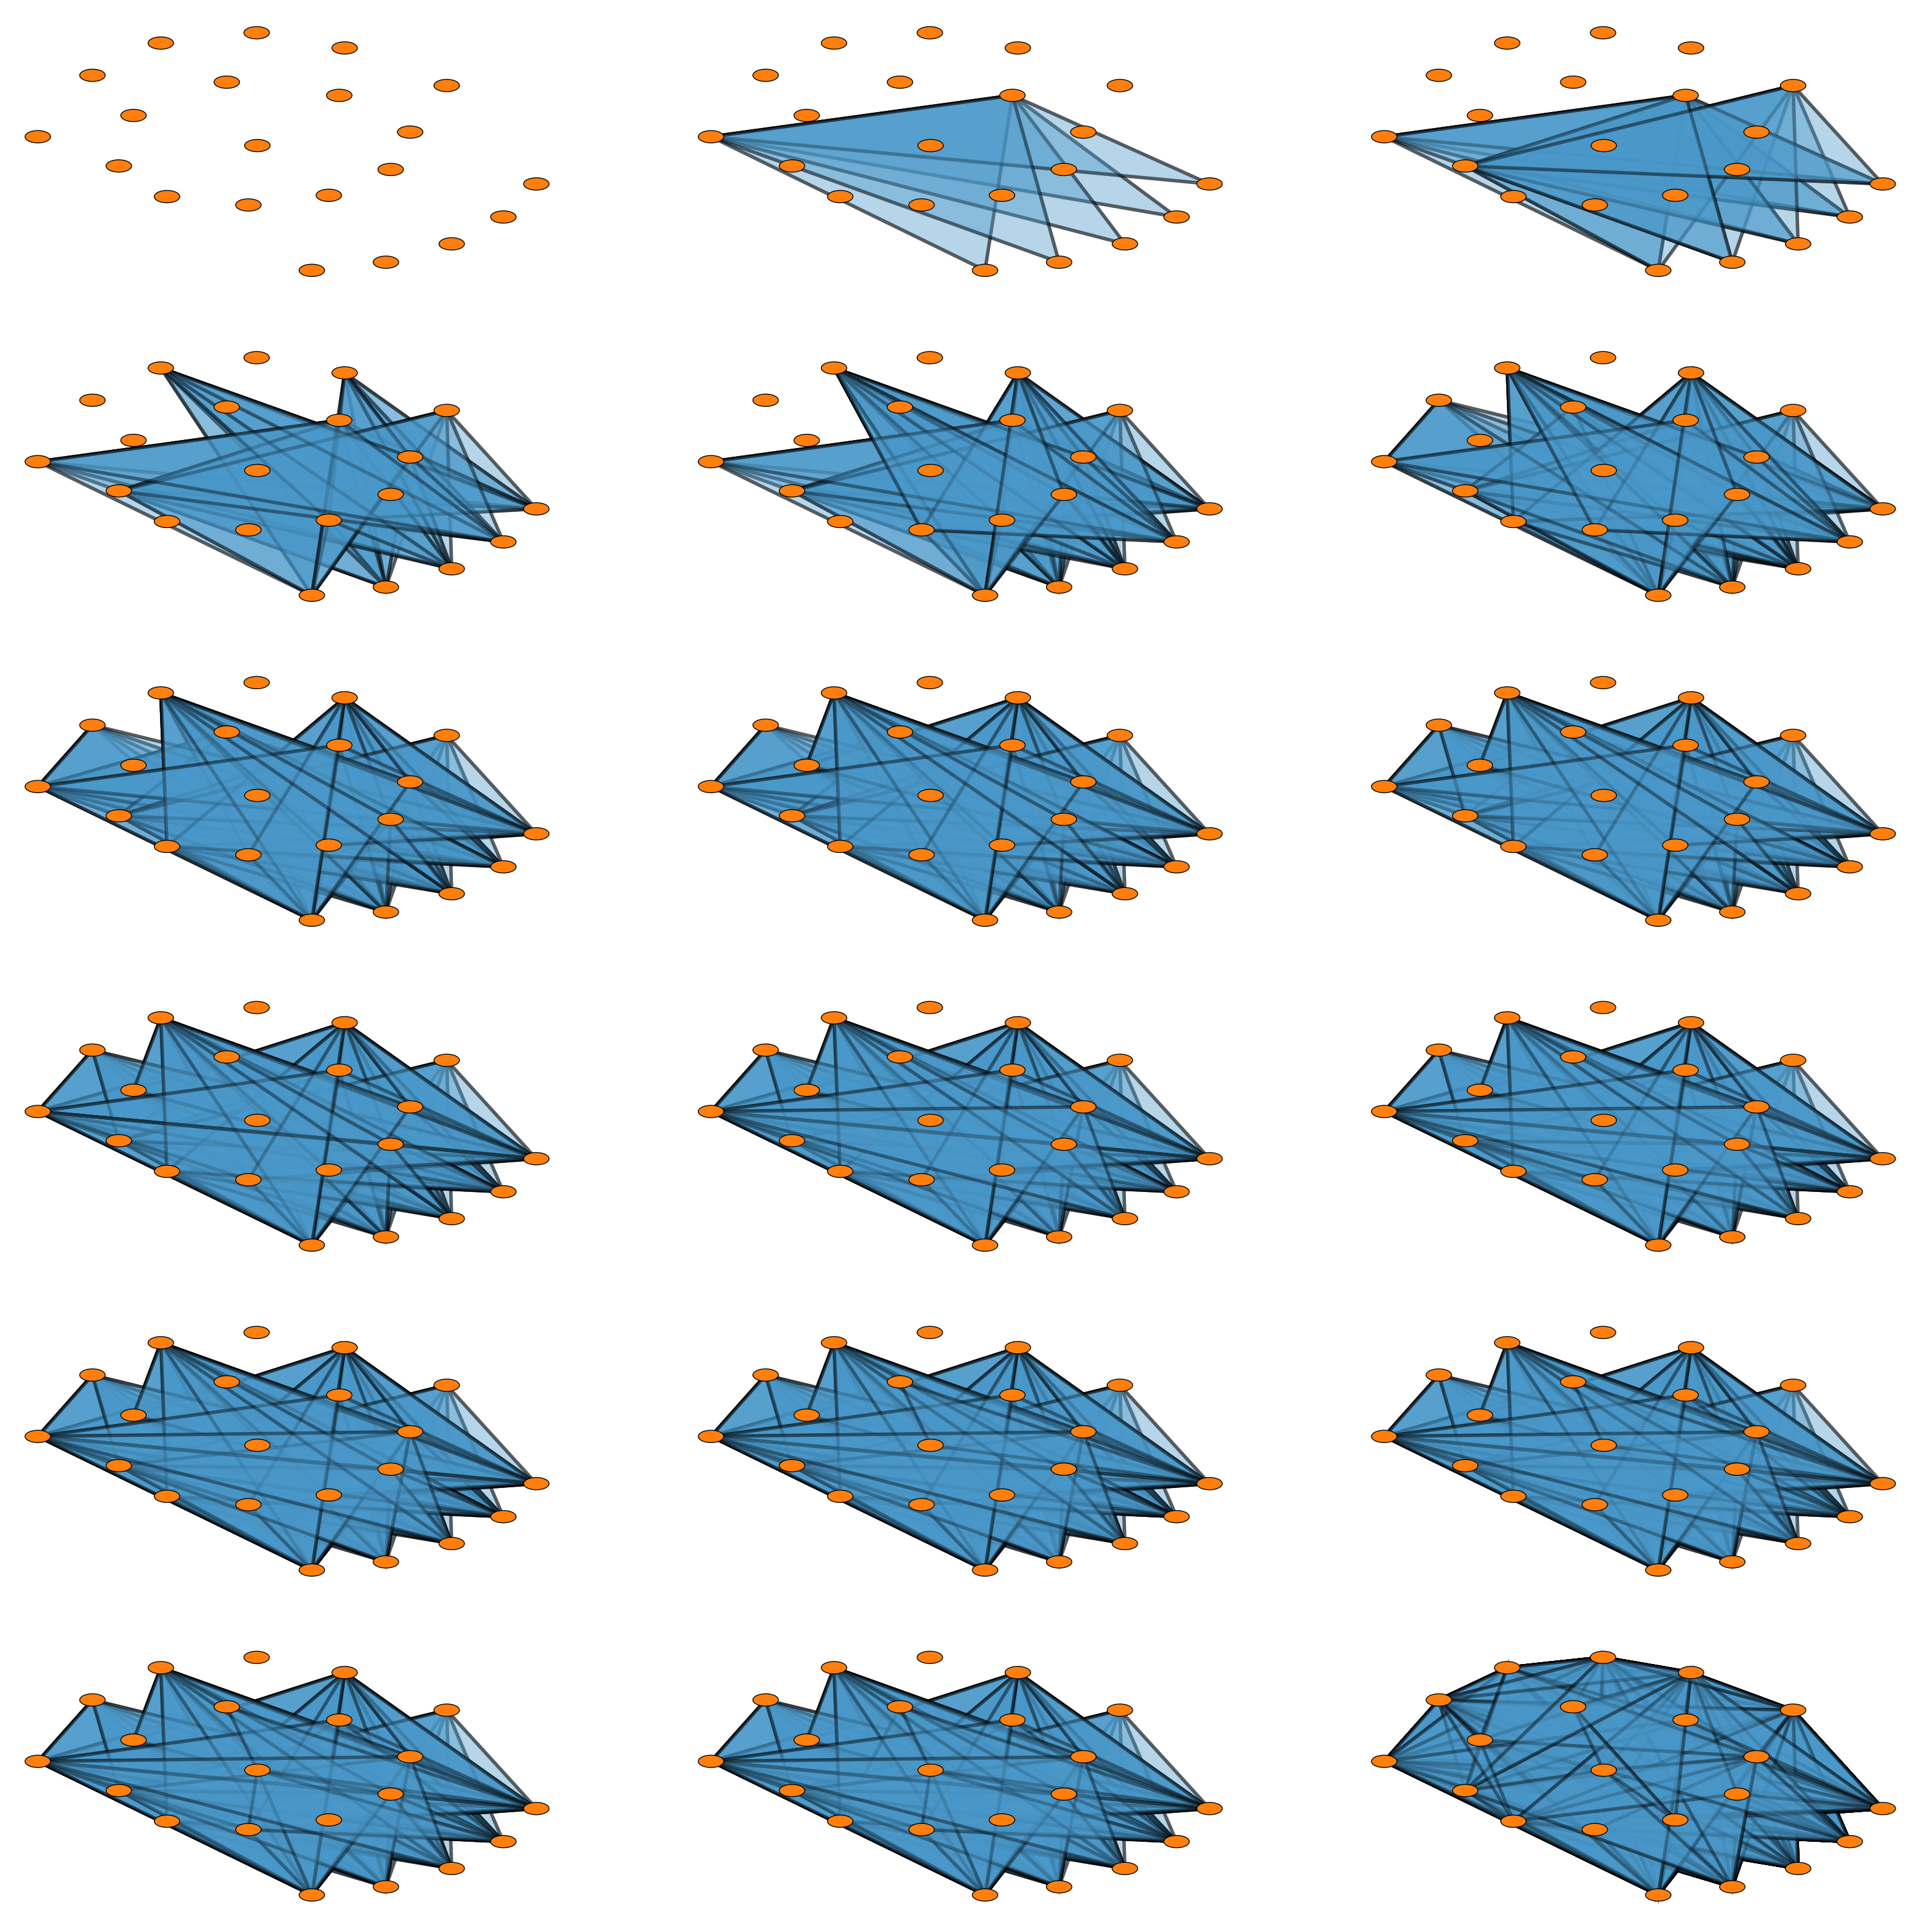

In [72]:
fig = plt.figure(figsize=(20,20))

for i, k in enumerate(sorted(inv_rl_SC.keys())):
    iSC = instant_complex(inv_rl_SC, k);
    ax = plt.subplot(6, 3, i+1)
    draw_2d_simplicial_complex(iSC, pos=skel_pos, ax=ax)